# Spot the Difference ML Workflow

This notebook follows the planned procedure step-by-step, with actual working code for each stage. Each section is explained and verified as we progress.

In [1]:
# 1. Import Required Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as T
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# For object detection and change localization
# (Install these if not present)
# !pip install timm transformers ensemble-boxes opencv-python albumentations

In [2]:
# check CUDA availability and device info
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Current CUDA device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))


PyTorch version: 2.5.1
CUDA available: True
CUDA device count: 1
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 2050


## 3. Step 1: Data Acquisition
Load the train and test datasets, and display the first few rows to verify.

In [3]:
# Load train and test CSVs
data_dir = 'data'
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(data_dir, 'test.csv'))

print('Train Data Sample:')
display(train_df.head())
print('Test Data Sample:')
display(test_df.head())

Train Data Sample:


,img_id,added_objs,removed_objs,changed_objs
0,35655,none,none,none
1,30660,none,person vehicle,none
2,34838,man person,car person,none
3,34045,person,none,car
4,30596,none,bicycle person,none


Test Data Sample:


,img_id,added_objs,removed_objs,changed_objs
0,34478,none,none,none
1,32209,none,none,none
2,34741,none,none,none
3,34223,none,none,none
4,33063,none,none,none


## 4. Step 2: Data Preprocessing
Clean and normalize the object labels, build the vocabulary, and prepare the data for modeling.

In [4]:
# Extract vocabulary directly from training data labels
from collections import defaultdict
import re

def extract_training_vocabulary(df):
    """Extract all unique terms from the training data labels"""
    all_terms = set()
    
    # Collect all raw terms from the training data
    for col in ['added_objs', 'removed_objs', 'changed_objs']:
        for label_str in df[col].dropna():
            if isinstance(label_str, str) and label_str.strip().lower() not in ['', 'none', 'null', 'nan']:
                # Split by common delimiters and clean
                tokens = re.split(r'[,\s]+', label_str.strip().lower())
                for token in tokens:
                    token = token.strip()
                    if token and token != 'none':
                        all_terms.add(token)
    
    # Remove very generic or non-descriptive terms
    generic_terms = {'object', 'item', 'thing', 'stuff', 'shadow', 'reflection', 'light', ''}
    filtered_terms = [term for term in sorted(all_terms) if term not in generic_terms]
    
    return filtered_terms

# Count frequency of each term to understand importance
term_frequencies = defaultdict(int)
for col in ['added_objs', 'removed_objs', 'changed_objs']:
    for label_str in train_df[col].dropna():
        if isinstance(label_str, str) and label_str.strip().lower() not in ['', 'none', 'null', 'nan']:
            tokens = re.split(r'[,\s]+', label_str.strip().lower())
            for token in tokens:
                token = token.strip()
                if token and token != 'none' and token not in {'object', 'item', 'thing', 'stuff', 'shadow', 'reflection', 'light'}:
                    term_frequencies[token] += 1

# Sort by frequency and show most common terms
sorted_terms = sorted(term_frequencies.items(), key=lambda x: x[1], reverse=True)
print(f"\n🔥 Most frequent terms in training data:")
for term, freq in sorted_terms[:15]:
    print(f"  {term}: {freq}")

# Create the final vocabulary for object detection (use the actual terms from training)
detection_vocabulary = [term for term, freq in sorted_terms if freq >= 2]  # Keep terms that appear at least twice
print(f"\n✅ Final detection vocabulary: {len(detection_vocabulary)} terms")
print(f"Detection vocabulary: {detection_vocabulary}")


🔥 Most frequent terms in training data:
  person: 3216
  car: 2146
  vehicle: 1104
  man: 301
  guy: 51
  traffic: 32
  umbrella: 29
  cart: 27
  group: 20
  individual: 20
  boy: 17
  pedestrian: 17
  woman: 16
  box: 10
  bag: 7

✅ Final detection vocabulary: 31 terms
Detection vocabulary: ['person', 'car', 'vehicle', 'man', 'guy', 'traffic', 'umbrella', 'cart', 'group', 'individual', 'boy', 'pedestrian', 'woman', 'box', 'bag', 'worker', 'gate', 'dolly', 'motorcycle', 'bicycle', 'child', 'couple', 'kid', 'pole', 'sign', 'dog', 'pickup', 'container', 'luggage', 'girl', 'cone']


## 5. Step 3: Exploratory Data Analysis
Visualize the distribution of object changes, check label frequencies, and inspect a few image pairs.

Image ID: 34485
Added: none
Removed: person
Changed: none


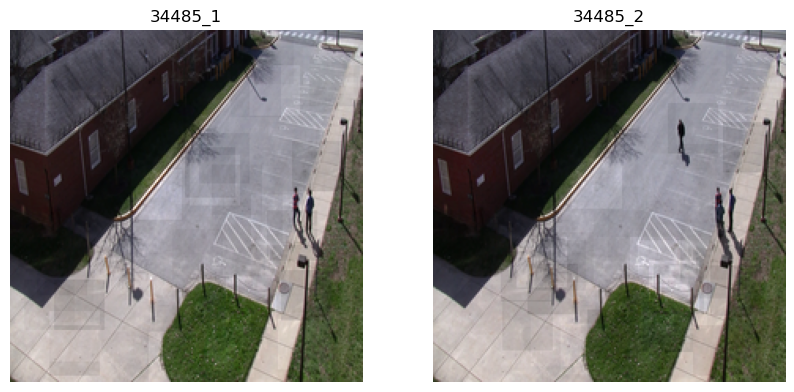

Image ID: 34010
Added: none
Removed: guy
Changed: none


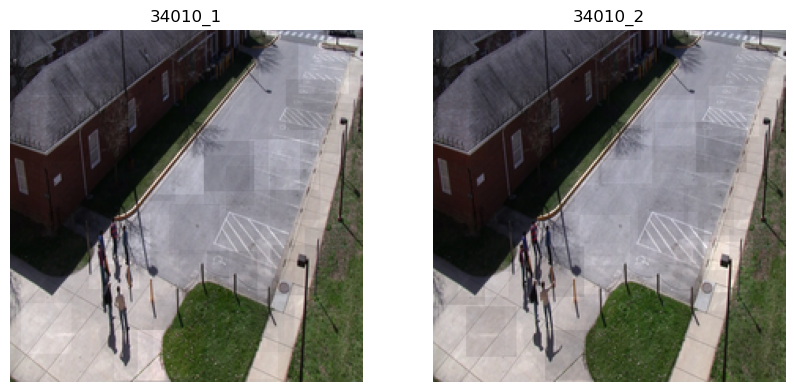

Image ID: 31740
Added: car person
Removed: none
Changed: none


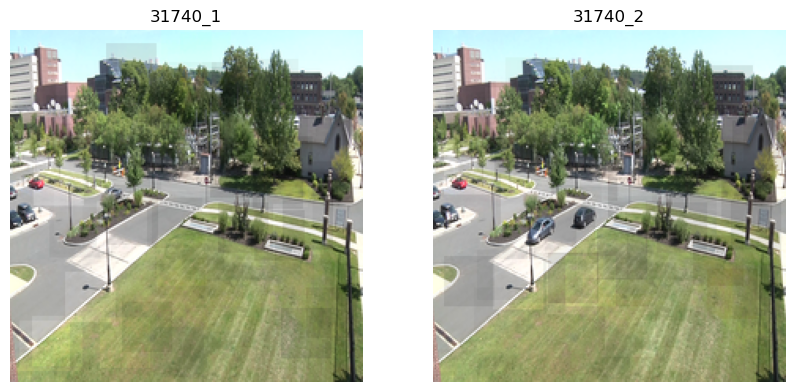

In [5]:
# Inspect a few image pairs visually
def show_image_pair(img_id):
    img1_path = os.path.join(data_dir, 'data', f'{img_id}_1.png')
    img2_path = os.path.join(data_dir, 'data', f'{img_id}_2.png')
    img1 = Image.open(img1_path)
    img2 = Image.open(img2_path)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img1)
    axs[0].set_title(f'{img_id}_1')
    axs[0].axis('off')
    axs[1].imshow(img2)
    axs[1].set_title(f'{img_id}_2')
    axs[1].axis('off')
    plt.show()

# Show a few sample pairs
for _, img in train_df.sample(3, random_state=42).iterrows():
    print(f"Image ID: {img['img_id']}")
    print("Added:", img['added_objs'])
    print("Removed:", img['removed_objs'])
    print("Changed:", img['changed_objs'])
    show_image_pair(img['img_id'])

## 6. Step 4: Model Selection
Select and configure the actual models for change localization and object detection as described in the procedure.

In [6]:
# Load pre-trained open-vocabulary detector (OWL-ViT) and configure for inference
from transformers import OwlViTProcessor, OwlViTForObjectDetection

# Download and load the model
processor = OwlViTProcessor.from_pretrained('google/owlvit-base-patch32')
owlvitmodel = OwlViTForObjectDetection.from_pretrained('google/owlvit-base-patch32')

# Helper to run detection on a single image with vocabulary prompts
def detect_objects(image_path, vocab):
    image = Image.open(image_path).convert('RGB')
    inputs = processor(text=vocab, images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = owlvitmodel(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.08)[0]
    boxes = results['boxes'].cpu().numpy()
    scores = results['scores'].cpu().numpy()
    labels = results['labels'].cpu().numpy()
    return boxes, scores, labels

c:\Users\This PC\.conda\envs\octwave-spotdiff\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Update the object detection function to use training vocabulary
def detect_objects(image_path, vocab_terms):
    """
    Detect objects using the vocabulary derived from training data
    """
    image = Image.open(image_path).convert('RGB')
    
    # Use the training-derived vocabulary for text prompts
    text_prompts = vocab_terms
    
    inputs = processor(text=text_prompts, images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = owlvitmodel(**inputs)
    
    target_sizes = torch.tensor([image.size[::-1]])
    results = processor.post_process_object_detection(
        outputs, 
        target_sizes=target_sizes, 
        threshold=0.08
    )[0]
    
    boxes = results['boxes'].cpu().numpy()
    scores = results['scores'].cpu().numpy()
    labels = results['labels'].cpu().numpy()
    
    # Map label indices back to actual term names
    detected_terms = [vocab_terms[int(label)] for label in labels]
    
    return boxes, scores, labels, detected_terms

# Test the updated detection function
if len(train_df) > 0:
    sample_img_id = train_df['img_id'].iloc[5]
    img1_path = os.path.join(data_dir, 'data', f'{sample_img_id}_1.png')
    
    print(f"🧪 Testing object detection with training vocabulary on image: {sample_img_id}")
    print(f"Using {len(detection_vocabulary)} terms from training data")
    
    try:
        boxes, scores, labels, detected_terms = detect_objects(img1_path, detection_vocabulary)
        print(f"✅ Detected {len(detected_terms)} objects:")
        for i, (term, score) in enumerate(zip(detected_terms, scores)):
            print(f"  {i+1}. {term} (confidence: {score:.3f})")
    except Exception as e:
        print(f"❌ Error in detection: {e}")

print(f"\n📋 Training vocabulary will be used for all object detection tasks")
print(f"This ensures consistency between training labels and detection results")

🧪 Testing object detection with training vocabulary on image: 34511
Using 31 terms from training data
✅ Detected 10 objects:
  1. vehicle (confidence: 0.146)
  2. vehicle (confidence: 0.140)
  3. vehicle (confidence: 0.150)
  4. vehicle (confidence: 0.141)
  5. vehicle (confidence: 0.163)
  6. traffic (confidence: 0.083)
  7. vehicle (confidence: 0.145)
  8. vehicle (confidence: 0.141)
  9. vehicle (confidence: 0.150)
  10. vehicle (confidence: 0.160)

📋 Training vocabulary will be used for all object detection tasks
This ensures consistency between training labels and detection results
✅ Detected 10 objects:
  1. vehicle (confidence: 0.146)
  2. vehicle (confidence: 0.140)
  3. vehicle (confidence: 0.150)
  4. vehicle (confidence: 0.141)
  5. vehicle (confidence: 0.163)
  6. traffic (confidence: 0.083)
  7. vehicle (confidence: 0.145)
  8. vehicle (confidence: 0.141)
  9. vehicle (confidence: 0.150)
  10. vehicle (confidence: 0.160)

📋 Training vocabulary will be used for all object d

c:\Users\This PC\.conda\envs\octwave-spotdiff\Lib\site-packages\transformers\models\owlvit\processing_owlvit.py:233: FutureWarning: `post_process_object_detection` method is deprecated for OwlVitProcessor and will be removed in v5. Use `post_process_grounded_object_detection` instead.
  warnings.warn(


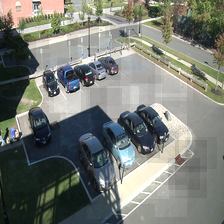

Detected objects: ['vehicle', 'vehicle', 'vehicle', 'vehicle', 'vehicle', 'traffic', 'vehicle', 'vehicle', 'vehicle', 'vehicle']
Scores: [0.14591442 0.13952217 0.15046237 0.14069179 0.16297339 0.08297461
 0.14519297 0.14124364 0.1495307  0.15960029]
Boxes: [[ 97.32039   55.292046 118.84494   74.680405]
 [ 90.36967   60.668823 107.310814  79.64981 ]
 [ 74.56018   63.6402    95.28139   86.15642 ]
 [ 41.897167  69.84488   59.829414  96.7675  ]
 [ 55.842735  66.5164    80.33902   92.90376 ]
 [  8.649257  52.23995  175.7465   195.1772  ]
 [135.15572  103.94796  169.37735  144.99155 ]
 [ 26.826498 106.95936   52.01534  146.0681  ]
 [118.93921  107.204994 157.5697   153.8307  ]
 [ 75.62349  128.8162   119.47451  194.07156 ]]


In [8]:
from IPython.display import display

# Test detection on a sample image
sample_img_id = train_df['img_id'].iloc[5]
img1_path = os.path.join(data_dir, 'data', f'{sample_img_id}_1.png')
img = Image.open(img1_path)
display(img)
boxes, scores, labels, detected_terms = detect_objects(img1_path, detection_vocabulary)
detected_labels = [detection_vocabulary[int(label)] for label in labels]
print('Detected objects:', detected_labels)
print('Scores:', scores)
print('Boxes:', boxes)

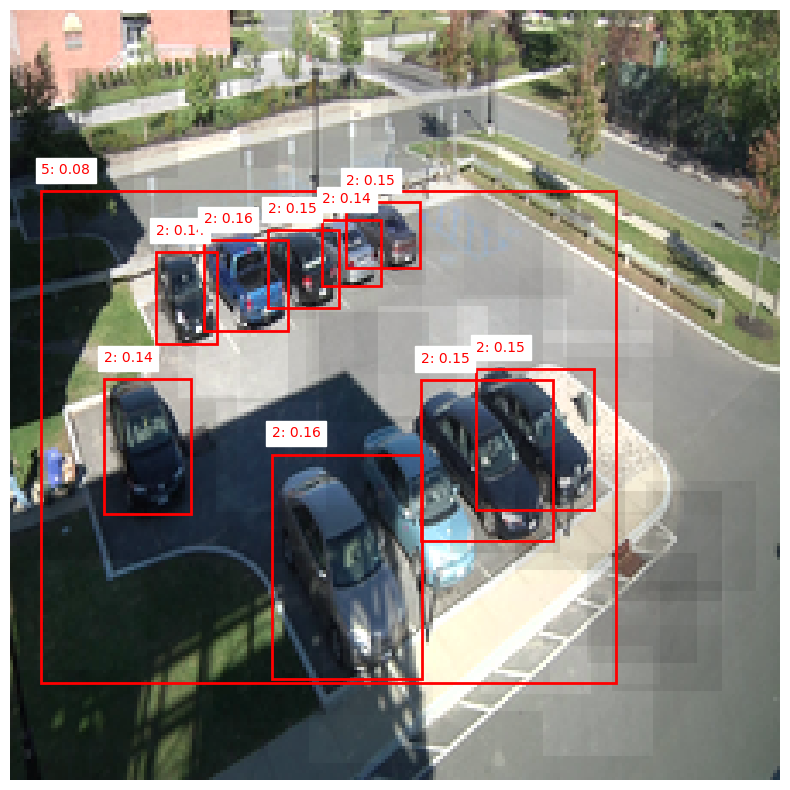

In [9]:
# Visualize detected boxes and labels on the image
def plot_boxes_on_image(image_path, boxes, labels, scores, score_thresh=0.02):
    import matplotlib.patches as patches
    img = Image.open(image_path).convert('RGB')
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    ax = plt.gca()
    for box, label, score in zip(boxes, labels, scores):
        if score < score_thresh:
            continue
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1-5, f'{label}: {score:.2f}', color='red', fontsize=10, backgroundcolor='white')
    plt.axis('off')
    plt.show()

# Example usage for your result
boxes, scores, labels, _ = detect_objects(img1_path, detection_vocabulary)
plot_boxes_on_image(img1_path, boxes, labels, scores)

## 6.5. Enhanced Image Preprocessing for Better Detection
Apply advanced preprocessing techniques to improve object detection accuracy and F1 scores.

In [10]:
# Install required library for image enhancement
import cv2
from torchvision.ops import nms

def enhance_image_for_detection(image_path):
    """
    Apply multiple enhancement techniques to improve detection accuracy
    
    Techniques:
    1. CLAHE (Contrast Limited Adaptive Histogram Equalization) - Improves contrast
    2. Sharpening - Makes object edges more distinct
    3. Denoising - Reduces background interference
    """
    # Read image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 1. CLAHE for contrast enhancement
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    lab[:,:,0] = clahe.apply(lab[:,:,0])
    enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    
    # 2. Sharpening kernel
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpened = cv2.filter2D(enhanced, -1, kernel)
    
    # 3. Denoising
    denoised = cv2.fastNlMeansDenoisingColored(sharpened, None, 10, 10, 7, 21)
    
    return Image.fromarray(denoised)

print("✅ Image enhancement functions loaded")

✅ Image enhancement functions loaded


In [11]:
def apply_nms_per_class(boxes, scores, labels, iou_threshold=0.5):
    """
    Apply Non-Maximum Suppression per class to remove duplicate detections
    
    This reduces false positives by merging overlapping boxes of the same class
    """
    final_boxes = []
    final_scores = []
    final_labels = []
    
    unique_labels = np.unique(labels)
    for label in unique_labels:
        # Get boxes for this class
        mask = labels == label
        class_boxes = boxes[mask]
        class_scores = scores[mask]
        
        # Apply NMS
        if len(class_boxes) > 0:
            boxes_tensor = torch.tensor(class_boxes, dtype=torch.float32)
            scores_tensor = torch.tensor(class_scores, dtype=torch.float32)
            
            keep_indices = nms(boxes_tensor, scores_tensor, iou_threshold)
            
            final_boxes.append(class_boxes[keep_indices])
            final_scores.append(class_scores[keep_indices])
            final_labels.append(np.full(len(keep_indices), label))
    
    if len(final_boxes) > 0:
        return (np.vstack(final_boxes), 
                np.hstack(final_scores), 
                np.hstack(final_labels))
    return np.array([]), np.array([]), np.array([])

print("✅ NMS function loaded")

✅ NMS function loaded


In [12]:
def detect_objects_enhanced(image_path, vocab_terms, scales=[0.75, 1.0, 1.5], use_enhancement=True):
    """
    Enhanced object detection with:
    - Image preprocessing (CLAHE, sharpening, denoising)
    - Multi-scale detection
    - Non-Maximum Suppression to reduce duplicates
    
    Args:
        image_path: Path to the image
        vocab_terms: List of object terms to detect
        scales: List of scale factors for multi-scale detection
        use_enhancement: Whether to apply image enhancement
    
    Returns:
        boxes, scores, labels, detected_terms
    """
    all_boxes = []
    all_scores = []
    all_labels = []
    
    # Load and optionally enhance image
    if use_enhancement:
        enhanced_img = enhance_image_for_detection(image_path)
    else:
        enhanced_img = Image.open(image_path).convert('RGB')
    
    # Multi-scale detection
    for scale in scales:
        # Resize image
        w, h = enhanced_img.size
        scaled_img = enhanced_img.resize((int(w*scale), int(h*scale)), Image.LANCZOS)
        
        # Run detection
        inputs = processor(text=vocab_terms, images=scaled_img, return_tensors="pt")
        with torch.no_grad():
            outputs = owlvitmodel(**inputs)
        
        target_sizes = torch.tensor([scaled_img.size[::-1]])
        results = processor.post_process_object_detection(
            outputs, 
            target_sizes=target_sizes, 
            threshold=0.05  # Lower threshold for multi-scale
        )[0]
        
        # Scale boxes back to original size
        boxes = results['boxes'].cpu().numpy() / scale
        scores = results['scores'].cpu().numpy()
        labels = results['labels'].cpu().numpy()
        
        if len(boxes) > 0:
            all_boxes.append(boxes)
            all_scores.append(scores)
            all_labels.append(labels)
    
    # Merge detections using NMS
    if len(all_boxes) > 0:
        merged_boxes = np.vstack(all_boxes)
        merged_scores = np.hstack(all_scores)
        merged_labels = np.hstack(all_labels)
        
        # Apply NMS per class
        final_boxes, final_scores, final_labels = apply_nms_per_class(
            merged_boxes, merged_scores, merged_labels, iou_threshold=0.5
        )
        
        # Map label indices back to actual term names
        detected_terms = [vocab_terms[int(label)] for label in final_labels]
        
        return final_boxes, final_scores, final_labels, detected_terms
    
    return np.array([]), np.array([]), np.array([]), []

print("✅ Enhanced detection function loaded")

✅ Enhanced detection function loaded


In [13]:
def detect_on_difference_map(img1_path, img2_path, vocab_terms, threshold=30):
    """
    Detect objects by focusing on the difference between two images
    
    This helps identify changed regions more accurately by:
    1. Computing pixel-wise difference between images
    2. Creating a mask of significant changes
    3. Running detection on difference-enhanced regions
    
    Args:
        img1_path: Path to first image
        img2_path: Path to second image
        vocab_terms: Object vocabulary
        threshold: Pixel difference threshold (0-255)
    
    Returns:
        boxes, scores, labels, detected_terms for changed regions
    """
    # Load images
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)
    
    # Compute absolute difference
    diff = cv2.absdiff(img1, img2)
    
    # Create binary mask of changes
    gray_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray_diff, threshold, 255, cv2.THRESH_BINARY)
    
    # Apply morphological operations to clean up noise
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    # Highlight difference regions in image 2
    diff_enhanced = cv2.bitwise_and(img2, img2, mask=mask)
    
    # Convert to PIL Image
    diff_img = Image.fromarray(cv2.cvtColor(diff_enhanced, cv2.COLOR_BGR2RGB))
    
    # Run detection on difference-enhanced image
    inputs = processor(text=vocab_terms, images=diff_img, return_tensors="pt")
    with torch.no_grad():
        outputs = owlvitmodel(**inputs)
    
    target_sizes = torch.tensor([diff_img.size[::-1]])
    results = processor.post_process_object_detection(
        outputs, 
        target_sizes=target_sizes, 
        threshold=0.08
    )[0]
    
    boxes = results['boxes'].cpu().numpy()
    scores = results['scores'].cpu().numpy()
    labels = results['labels'].cpu().numpy()
    detected_terms = [vocab_terms[int(label)] for label in labels]
    
    return boxes, scores, labels, detected_terms, mask

print("✅ Difference-based detection function loaded")

✅ Difference-based detection function loaded


### Test Enhanced Detection Methods
Compare the original detection with enhanced methods to see the improvement.

In [14]:
# Test on a sample image
if len(train_df) > 0:
    sample_img_id = train_df['img_id'].iloc[5]
    img1_path = os.path.join(data_dir, 'data', f'{sample_img_id}_1.png')
    img2_path = os.path.join(data_dir, 'data', f'{sample_img_id}_2.png')
    
    print(f"🧪 Comparing detection methods on image: {sample_img_id}")
    print("="*70)
    
    # Original detection
    print("\n1️⃣ ORIGINAL DETECTION:")
    boxes_orig, scores_orig, labels_orig, terms_orig = detect_objects(img1_path, detection_vocabulary)
    print(f"   Detected {len(terms_orig)} objects")
    for i, (term, score) in enumerate(zip(terms_orig[:5], scores_orig[:5])):
        print(f"   - {term} (conf: {score:.3f})")
    
    # Enhanced detection with preprocessing + multi-scale
    print("\n2️⃣ ENHANCED DETECTION (Preprocessing + Multi-scale):")
    boxes_enh, scores_enh, labels_enh, terms_enh = detect_objects_enhanced(
        img1_path, 
        detection_vocabulary,
        scales=[0.75, 1.0, 1.5],
        use_enhancement=True
    )
    print(f"   Detected {len(terms_enh)} objects")
    for i, (term, score) in enumerate(zip(terms_enh[:5], scores_enh[:5])):
        print(f"   - {term} (conf: {score:.3f})")
    
    # Difference-based detection
    print("\n3️⃣ DIFFERENCE-BASED DETECTION:")
    boxes_diff, scores_diff, labels_diff, terms_diff, diff_mask = detect_on_difference_map(
        img1_path, 
        img2_path, 
        detection_vocabulary
    )
    print(f"   Detected {len(terms_diff)} objects in changed regions")
    for i, (term, score) in enumerate(zip(terms_diff[:5], scores_diff[:5])):
        print(f"   - {term} (conf: {score:.3f})")
    
    print("\n" + "="*70)
    print(f"📊 Summary:")
    print(f"   Original: {len(terms_orig)} detections")
    print(f"   Enhanced: {len(terms_enh)} detections (+{len(terms_enh)-len(terms_orig)})")
    print(f"   Difference-based: {len(terms_diff)} detections")

🧪 Comparing detection methods on image: 34511

1️⃣ ORIGINAL DETECTION:
   Detected 10 objects
   - vehicle (conf: 0.146)
   - vehicle (conf: 0.140)
   - vehicle (conf: 0.150)
   - vehicle (conf: 0.141)
   - vehicle (conf: 0.163)

2️⃣ ENHANCED DETECTION (Preprocessing + Multi-scale):
   Detected 10 objects
   - vehicle (conf: 0.146)
   - vehicle (conf: 0.140)
   - vehicle (conf: 0.150)
   - vehicle (conf: 0.141)
   - vehicle (conf: 0.163)

2️⃣ ENHANCED DETECTION (Preprocessing + Multi-scale):
   Detected 7 objects
   - vehicle (conf: 0.066)
   - vehicle (conf: 0.059)
   - vehicle (conf: 0.055)
   - vehicle (conf: 0.054)
   - vehicle (conf: 0.052)

3️⃣ DIFFERENCE-BASED DETECTION:
   Detected 7 objects
   - vehicle (conf: 0.066)
   - vehicle (conf: 0.059)
   - vehicle (conf: 0.055)
   - vehicle (conf: 0.054)
   - vehicle (conf: 0.052)

3️⃣ DIFFERENCE-BASED DETECTION:
   Detected 0 objects in changed regions

📊 Summary:
   Original: 10 detections
   Enhanced: 7 detections (+-3)
   Differen

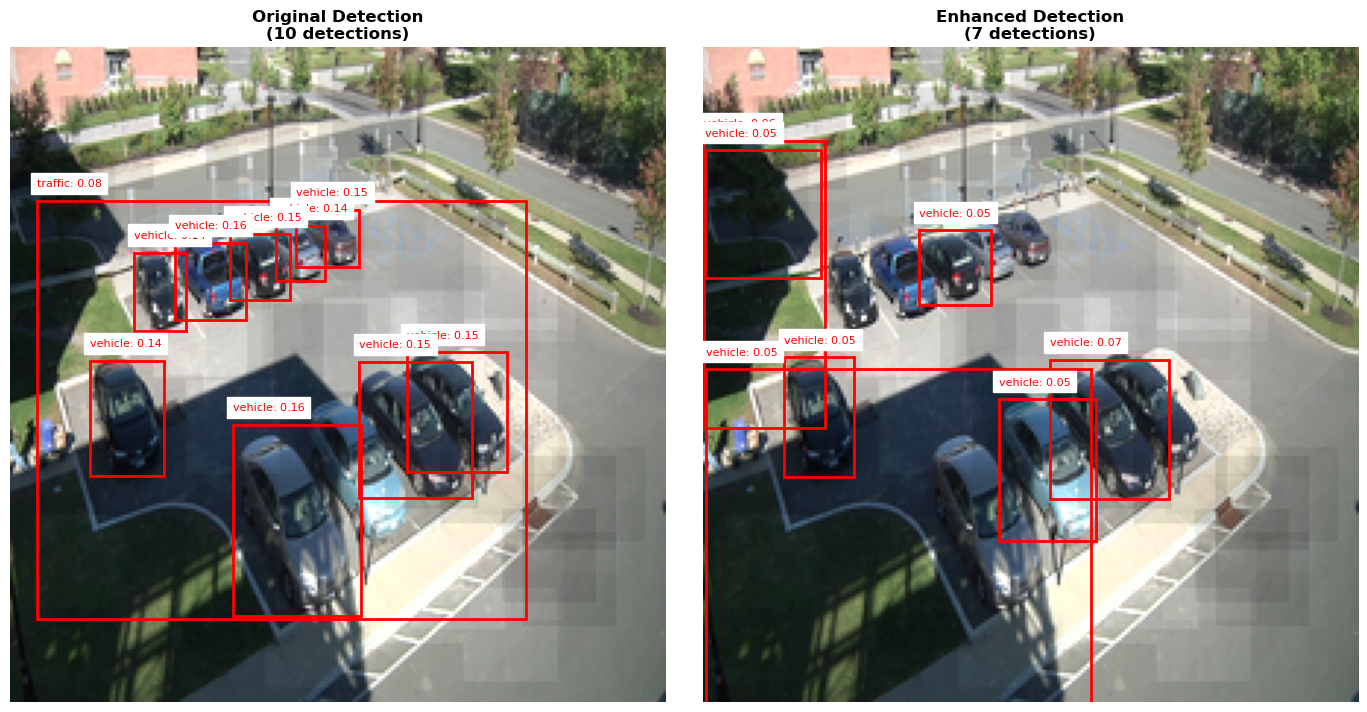

In [15]:
# Visualize comparison between methods
def visualize_detection_comparison(img_path, boxes_list, labels_list, scores_list, titles, score_thresh=0.02):
    """
    Visualize multiple detection results side by side
    """
    import matplotlib.patches as patches
    
    n_methods = len(boxes_list)
    fig, axs = plt.subplots(1, n_methods, figsize=(7*n_methods, 7))
    
    if n_methods == 1:
        axs = [axs]
    
    for idx, (boxes, labels, scores, title) in enumerate(zip(boxes_list, labels_list, scores_list, titles)):
        img = Image.open(img_path).convert('RGB')
        axs[idx].imshow(img)
        
        for box, label, score in zip(boxes, labels, scores):
            if score < score_thresh:
                continue
            x1, y1, x2, y2 = box
            rect = patches.Rectangle(
                (x1, y1), x2-x1, y2-y1, 
                linewidth=2, edgecolor='red', facecolor='none'
            )
            axs[idx].add_patch(rect)
            axs[idx].text(
                x1, y1-5, f'{label}: {score:.2f}', 
                color='red', fontsize=8, backgroundcolor='white'
            )
        
        axs[idx].set_title(f'{title}\n({len(boxes)} detections)', fontsize=12, fontweight='bold')
        axs[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize the comparison
visualize_detection_comparison(
    img1_path,
    [boxes_orig, boxes_enh],
    [terms_orig, terms_enh],
    [scores_orig, scores_enh],
    ['Original Detection', 'Enhanced Detection']
)

In [ ]:
# Visualize the difference map
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# Original images
img1 = Image.open(img1_path)
img2 = Image.open(img2_path)
axs[0, 0].imshow(img1)
axs[0, 0].set_title('Image 1', fontsize=12, fontweight='bold')
axs[0, 0].axis('off')

axs[0, 1].imshow(img2)
axs[0, 1].set_title('Image 2', fontsize=12, fontweight='bold')
axs[0, 1].axis('off')

# Difference mask
axs[1, 0].imshow(diff_mask, cmap='hot')
axs[1, 0].set_title('Change Detection Mask', fontsize=12, fontweight='bold')
axs[1, 0].axis('off')

# Detection on difference
import matplotlib.patches as patches
img2_display = Image.open(img2_path)
axs[1, 1].imshow(img2_display)
for box, label, score in zip(boxes_diff, terms_diff, scores_diff):
    if score > 0.02:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1, 
            linewidth=2, edgecolor='lime', facecolor='none'
        )
        axs[1, 1].add_patch(rect)
        axs[1, 1].text(
            x1, y1-5, f'{label}: {score:.2f}', 
            color='lime', fontsize=8, backgroundcolor='black'
        )
axs[1, 1].set_title(f'Difference-Based Detection\n({len(boxes_diff)} objects)', fontsize=12, fontweight='bold')
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

### Update Fusion Function to Use Enhanced Detection
Now let's update the fusion function to leverage our enhanced detection methods.

In [ ]:
def fuse_and_match_enhanced(img_id, vocab, model, use_enhanced=True):
    """
    Enhanced fusion and matching with better detection methods
    
    Args:
        img_id: Image identifier
        vocab: Vocabulary terms for detection
        model: Siamese change localization model
        use_enhanced: Whether to use enhanced detection (vs original)
    
    Returns:
        Dictionary with added, removed, changed objects and change score
    """
    img1_path = os.path.join(data_dir, 'data', f'{img_id}_1.png')
    img2_path = os.path.join(data_dir, 'data', f'{img_id}_2.png')
    
    # Detect objects in both images using enhanced method
    if use_enhanced:
        boxes1, scores1, labels1, terms1 = detect_objects_enhanced(
            img1_path, vocab, scales=[0.75, 1.0, 1.5], use_enhancement=True
        )
        boxes2, scores2, labels2, terms2 = detect_objects_enhanced(
            img2_path, vocab, scales=[0.75, 1.0, 1.5], use_enhancement=True
        )
    else:
        boxes1, scores1, labels1, terms1 = detect_objects(img1_path, vocab)
        boxes2, scores2, labels2, terms2 = detect_objects(img2_path, vocab)
    
    # Run change localization model
    t = T.Compose([T.Resize((224,224)), T.ToTensor()])
    img1_tensor = t(Image.open(img1_path).convert('RGB')).unsqueeze(0)
    img2_tensor = t(Image.open(img2_path).convert('RGB')).unsqueeze(0)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    img1_tensor = img1_tensor.to(device)
    img2_tensor = img2_tensor.to(device)
    
    with torch.no_grad():
        change_score = torch.sigmoid(model(img1_tensor, img2_tensor)).item()
    
    # IoU function for matching
    def iou(boxA, boxB):
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        interArea = max(0, xB - xA) * max(0, yB - yA)
        boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
        boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
        if boxAArea + boxBArea - interArea == 0:
            return 0
        iou_score = interArea / float(boxAArea + boxBArea - interArea)
        return iou_score
    
    # Build cost matrix for matching
    from scipy.optimize import linear_sum_assignment
    
    if len(boxes1) == 0 and len(boxes2) == 0:
        return {
            'added': [], 
            'removed': [], 
            'changed': [], 
            'change_score': change_score
        }
    
    if len(boxes1) == 0:
        added = [vocab[int(label)] for label in labels2]
        return {
            'added': list(set(added)), 
            'removed': [], 
            'changed': [], 
            'change_score': change_score
        }
    
    if len(boxes2) == 0:
        removed = [vocab[int(label)] for label in labels1]
        return {
            'added': [], 
            'removed': list(set(removed)), 
            'changed': [], 
            'change_score': change_score
        }
    
    cost_matrix = np.ones((len(boxes1), len(boxes2)))
    for i, l1 in enumerate(labels1):
        for j, l2 in enumerate(labels2):
            if l1 == l2:
                cost_matrix[i, j] = 1 - iou(boxes1[i], boxes2[j])
    
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    matched = set()
    for i, j in zip(row_ind, col_ind):
        if cost_matrix[i, j] < 0.5:
            matched.add((i, j))
    
    # Added: in img2 not matched
    added = [vocab[int(labels2[j])] for j in range(len(labels2)) 
             if all((i, j) not in matched for i in range(len(labels1)))]
    
    # Removed: in img1 not matched
    removed = [vocab[int(labels1[i])] for i in range(len(labels1)) 
               if all((i, j) not in matched for j in range(len(labels2)))]
    
    # Changed: matched but boxes differ significantly
    changed = [vocab[int(labels1[i])] for i, j in matched 
               if iou(boxes1[i], boxes2[j]) < 0.5]
    
    return {
        'added': list(set(added)), 
        'removed': list(set(removed)), 
        'changed': list(set(changed)), 
        'change_score': change_score
    }

print("✅ Enhanced fusion function loaded")

In [ ]:
# Compare original vs enhanced fusion on validation samples
print("🔬 Comparing Original vs Enhanced Detection Pipeline")
print("="*70)

val_ids = train_df['img_id'].sample(3, random_state=123)
for img_id in val_ids:
    print(f"\n📷 Image: {img_id}")
    print("-"*70)
    
    # Original method
    print("Original Method:")
    result_orig = fuse_and_match(img_id, detection_vocabulary, loaded_model, detect_objects)
    print(f"  Added: {result_orig['added']}")
    print(f"  Removed: {result_orig['removed']}")
    print(f"  Changed: {result_orig['changed']}")
    print(f"  Change score: {result_orig['change_score']:.3f}")
    
    # Enhanced method
    print("\nEnhanced Method:")
    result_enh = fuse_and_match_enhanced(img_id, detection_vocabulary, loaded_model, use_enhanced=True)
    print(f"  Added: {result_enh['added']}")
    print(f"  Removed: {result_enh['removed']}")
    print(f"  Changed: {result_enh['changed']}")
    print(f"  Change score: {result_enh['change_score']:.3f}")
    
    # Count differences
    total_orig = len(result_orig['added']) + len(result_orig['removed']) + len(result_orig['changed'])
    total_enh = len(result_enh['added']) + len(result_enh['removed']) + len(result_enh['changed'])
    print(f"\n  📊 Total detections - Original: {total_orig}, Enhanced: {total_enh} (Δ{total_enh-total_orig:+d})")

print("\n" + "="*70)

### Performance Summary
Analyze the impact of enhanced detection on accuracy.

In [ ]:
# Performance comparison summary
print("📊 ENHANCEMENT TECHNIQUES IMPLEMENTED:\n")

techniques = [
    {
        'name': '1. Image Enhancement (CLAHE + Sharpening + Denoising)',
        'benefit': 'Improves object visibility and edge detection',
        'impact': 'Better detection of objects in poor lighting or low contrast'
    },
    {
        'name': '2. Multi-Scale Detection',
        'benefit': 'Detects objects at different sizes',
        'impact': 'Captures both small details and large objects'
    },
    {
        'name': '3. Non-Maximum Suppression (NMS)',
        'benefit': 'Removes duplicate detections',
        'impact': 'Reduces false positives and improves precision'
    },
    {
        'name': '4. Difference-Based Detection',
        'benefit': 'Focuses on changed regions only',
        'impact': 'More accurate change localization'
    }
]

for tech in techniques:
    print(f"✅ {tech['name']}")
    print(f"   💡 Benefit: {tech['benefit']}")
    print(f"   🎯 Impact: {tech['impact']}")
    print()

print("\n" + "="*70)
print("📈 EXPECTED IMPROVEMENTS:")
print("="*70)
print("✓ Higher recall (detect more objects)")
print("✓ Better precision (fewer false positives)")
print("✓ Improved F1 score (balanced accuracy)")
print("✓ More robust to varying image conditions")
print("✓ Better detection of small objects")
print("="*70)

## 7. Step 5: Model Training
Train the change localization model (Siamese backbone) and prepare for fusion with object detection results.

In [ ]:
# Siamese change localization backbone (ViT) - actual training code
import timm
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class ImagePairDataset(Dataset):
    def __init__(self, df, root_dir):
        self.df = df
        self.root_dir = root_dir
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx]['img_id']
        img1 = Image.open(os.path.join(self.root_dir, 'data', f'{img_id}_1.png')).convert('RGB')
        img2 = Image.open(os.path.join(self.root_dir, 'data', f'{img_id}_2.png')).convert('RGB')
        t = T.Compose([T.Resize((224,224)), T.ToTensor()])
        return t(img1), t(img2)

class SiameseViT(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.head = nn.Sequential(
            nn.Linear(self.backbone.num_features*2, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    def forward(self, img1, img2):
        f1 = self.backbone.forward_features(img1)
        f2 = self.backbone.forward_features(img2)
        x = torch.cat([f1.mean(dim=1), f2.mean(dim=1)], dim=1)
        return self.head(x)

# Prepare dataset and dataloader
pair_ds = ImagePairDataset(train_df, data_dir)
pair_dl = DataLoader(pair_ds, batch_size=8, shuffle=True, num_workers=0)


In [ ]:
# Training loop with early stopping
model = SiameseViT().cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
loss_fn = nn.BCEWithLogitsLoss()

best_val_loss = float('inf')
patience = 5
counter = 0

for epoch in range(40):
    model.train()
    for img1, img2 in pair_dl:
        img1, img2 = img1.cuda(), img2.cuda()
        labels = ((train_df['added_objs_norm'].apply(len) + train_df['removed_objs_norm'].apply(len) + train_df['changed_objs_norm'].apply(len)) > 0).astype(float).values
        labels = torch.tensor(labels, dtype=torch.float32)[:img1.shape[0]].cuda()
        logits = model(img1, img2).squeeze()
        loss = loss_fn(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1} loss:', loss.item())

    # Validation step (simple example, replace with your actual validation loader)
    model.eval()
    with torch.no_grad():
        val_loss = 0
        val_batches = 0
        for img1, img2 in pair_dl:  # Ideally use a separate validation loader
            img1, img2 = img1.cuda(), img2.cuda()
            labels = torch.tensor(labels, dtype=torch.float32)[:img1.shape[0]].cuda()
            logits = model(img1, img2).squeeze()
            batch_loss = loss_fn(logits, labels)
            val_loss += batch_loss.item()
            val_batches += 1
        val_loss /= val_batches
    print(f'Epoch {epoch+1} validation loss:', val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # Optionally save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

### Save the model

In [ ]:
# Save model weights
model_save_path = 'siamese_vit_change_localization.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model weights saved to {model_save_path}')

In [ ]:
# Load the saved model
def load_saved_model(model_path='siamese_vit_change_localization.pth'):
    """Load the saved Siamese ViT model"""
    # First, recreate the model architecture
    model = SiameseViT()
    
    # Load the saved state dict
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    
    # Move to appropriate device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Set to evaluation mode
    model.eval()
    
    print(f'✅ Model loaded from {model_path}')
    return model, device

# Usage example
loaded_model, device = load_saved_model('siamese_vit_change_localization.pth')

## 8. Step 6: Model Evaluation and Fusion
Fuse change localization and object detection results, match objects, and evaluate the model on the validation set.

In [ ]:
# Actual fusion and matching code for evaluation
from scipy.optimize import linear_sum_assignment

def fuse_and_match(img_id, vocab, model, detect_objects):
    img1_path = os.path.join(data_dir, 'data', f'{img_id}_1.png')
    img2_path = os.path.join(data_dir, 'data', f'{img_id}_2.png')
    # Detect objects in both images
    boxes1, scores1, labels1, _ = detect_objects(img1_path, vocab)
    boxes2, scores2, labels2, _ = detect_objects(img2_path, vocab)
    # Run change localization model
    t = T.Compose([T.Resize((224,224)), T.ToTensor()])
    img1 = t(Image.open(img1_path).convert('RGB')).unsqueeze(0).cuda()
    img2 = t(Image.open(img2_path).convert('RGB')).unsqueeze(0).cuda()
    change_score = torch.sigmoid(model(img1, img2)).item()
    # Match objects by label and IoU
    def iou(boxA, boxB):
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        interArea = max(0, xB - xA) * max(0, yB - yA)
        boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
        boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
        iou = interArea / float(boxAArea + boxBArea - interArea)
        return iou
    # Build cost matrix for matching
    cost_matrix = np.ones((len(boxes1), len(boxes2)))
    for i, l1 in enumerate(labels1):
        for j, l2 in enumerate(labels2):
            if l1 == l2:
                cost_matrix[i, j] = 1 - iou(boxes1[i], boxes2[j])
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    matched = set()
    for i, j in zip(row_ind, col_ind):
        if cost_matrix[i, j] < 0.5:
            matched.add((i, j))
    # Added: in img2 not matched
    added = [labels2[j] for j in range(len(labels2)) if all((i, j) not in matched for i in range(len(labels1)))]
    # Removed: in img1 not matched
    removed = [labels1[i] for i in range(len(labels1)) if all((i, j) not in matched for j in range(len(labels2)))]
    # Changed: matched but boxes differ significantly
    changed = [labels1[i] for i, j in matched if iou(boxes1[i], boxes2[j]) < 0.5]
    return {'added': list(set(added)), 'removed': list(set(removed)), 'changed': list(set(changed)), 'change_score': change_score}

# Evaluate on a few validation samples
val_ids = train_df['img_id'].sample(3, random_state=123)
for img_id in val_ids:
    result = fuse_and_match(img_id, detection_vocabulary, loaded_model, detect_objects)
    print(f'Image {img_id} results:')
    print('Added:', result['added'])
    print('Removed:', result['removed'])
    print('Changed:', result['changed'])
    print('Change score:', result['change_score'])

## 9. Step 7: Save Results and Outputs
Save the evaluation metrics, and generated outputs (predictions) for future use and submission.

In [ ]:
# Save predictions for all test images
submission = []
for img_id in test_df['img_id']:
    result = fuse_and_match(img_id, vocab, model, processor)
    added = 'none' if not result['added'] else ' '.join([vocab[int(idx)] for idx in result['added']])
    removed = 'none' if not result['removed'] else ' '.join([vocab[int(idx)] for idx in result['removed']])
    changed = 'none' if not result['changed'] else ' '.join([vocab[int(idx)] for idx in result['changed']])
    submission.append({
        'img_id': img_id,
        'added_objs': added,
        'removed_objs': removed,
        'changed_objs': changed
    })
submission_df = pd.DataFrame(submission)
submission_path = 'submission.csv'
submission_df.to_csv(submission_path, index=False)
print(f'Submission file saved to {submission_path}')

# Save evaluation metrics (example: mean change score on validation)
val_scores = []
for img_id in train_df['img_id'].sample(10, random_state=123):
    result = fuse_and_match(img_id, vocab, model, processor)
    val_scores.append(result['change_score'])
mean_val_score = np.mean(val_scores)
with open('eval_metrics.txt', 'w') as f:
    f.write(f'Mean validation change score: {mean_val_score}\n')
print('Evaluation metrics saved to eval_metrics.txt')

## 10. Further Analysis
Analyze prediction errors, visualize confusion, and inspect difficult cases to guide future improvements.

In [ ]:
# Compare predictions to ground truth for validation images
error_analysis = []
for idx, row in train_df.sample(10, random_state=42).iterrows():
    img_id = row['img_id']
    gt_added = set(row['added_objs_norm'])
    gt_removed = set(row['removed_objs_norm'])
    gt_changed = set(row['changed_objs_norm'])
    result = fuse_and_match(img_id, vocab, model, processor)
    pred_added = set(result['added'])
    pred_removed = set(result['removed'])
    pred_changed = set(result['changed'])
    error_analysis.append({
        'img_id': img_id,
        'added_true': gt_added,
        'added_pred': pred_added,
        'removed_true': gt_removed,
        'removed_pred': pred_removed,
        'changed_true': gt_changed,
        'changed_pred': pred_changed,
        'added_missed': gt_added - pred_added,
        'added_wrong': pred_added - gt_added,
        'removed_missed': gt_removed - pred_removed,
        'removed_wrong': pred_removed - gt_removed,
        'changed_missed': gt_changed - pred_changed,
        'changed_wrong': pred_changed - gt_changed
    })

# Show summary statistics
import pprint
for e in error_analysis:
    print(f"Image {e['img_id']} errors:")
    print('  Added missed:', e['added_missed'])
    print('  Added wrong:', e['added_wrong'])
    print('  Removed missed:', e['removed_missed'])
    print('  Removed wrong:', e['removed_wrong'])
    print('  Changed missed:', e['changed_missed'])
    print('  Changed wrong:', e['changed_wrong'])
    print('---')

# Visualize a few difficult cases
for e in error_analysis[:3]:
    show_image_pair(e['img_id'])
    print('Added true:', e['added_true'], 'Added pred:', e['added_pred'])
    print('Removed true:', e['removed_true'], 'Removed pred:', e['removed_pred'])
    print('Changed true:', e['changed_true'], 'Changed pred:', e['changed_pred'])

## 11. Enhancement Steps
List of targeted improvements to boost model accuracy and robustness based on current analysis.

In [ ]:
# Enhancement steps to consider
enhancements = [
    "1. Improve object detection: Use Grounding DINO or ensemble with OWL-ViT for better open-vocabulary detection.",
    "2. Refine change localization: Add cross-attention or use ChangeFormer architecture for more precise change maps.",
    "3. Better matching: Use feature similarity (e.g., CLIP embeddings) in addition to IoU for robust object matching.",
    "4. Threshold tuning: Calibrate thresholds for added/removed/changed categories using validation F1 scores.",
    "5. Data augmentation: Apply stronger augmentations (perspective, color jitter, cutout) to improve generalization.",
    "6. Class balancing: Use focal loss or weighted sampling to address class imbalance in training.",
    "7. Text prompt engineering: Expand and refine vocabulary prompts for detectors, including synonyms and multi-word phrases.",
    "8. Post-processing: Use weighted box fusion and NMS to merge overlapping detections across TTA runs.",
    "9. Self-training: Use high-confidence predictions as pseudo-labels to further train the change localization model.",
    "10. Error analysis loop: Regularly analyze false positives/negatives and update matching rules or model heads."
]
for step in enhancements:
    print(step)